# ResNet152 & MobileNetV3

In [57]:
DIR = "./dataset/realwaste-main/RealWaste"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, 
                                                                    subset="training", seed=42, 
                                                                    batch_size=16, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16, smart_resize=True)

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', 
                                                   include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
callbacks = tf.keras.callbacks.EarlyStopping(patience=4)

train_dataset_augmented = train_dataset.map(lambda x, y: (data_augmentation(x), y))
history = model.fit(train_dataset_augmented, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

Found 4752 files belonging to 9 classes.
Using 4277 files for training.
Found 4752 files belonging to 9 classes.
Using 475 files for validation.
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'] 9
Epoch 1/50
268/268 [==============================] - 76s 267ms/step - loss: 2.2347 - accuracy: 0.2212 - val_loss: 5.8534 - val_accuracy: 0.1284
Epoch 2/50
268/268 [==============================] - 70s 262ms/step - loss: 2.0039 - accuracy: 0.2719 - val_loss: 17.7281 - val_accuracy: 0.1305
Epoch 3/50
268/268 [==============================] - 72s 267ms/step - loss: 1.9360 - accuracy: 0.2862 - val_loss: 37.9300 - val_accuracy: 0.1495
Epoch 4/50
112/268 [===========>..................] - ETA: 38s - loss: 1.9086 - accuracy: 0.2824

KeyboardInterrupt: 

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications import MobileNetV2, InceptionResNetV2, DenseNet121, ResNet50, InceptionV3
from keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Sequential
import numpy as np
import os
import torch
import keras
import pycocotools
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from  PIL import ImageDraw
import os.path as path
import re
from sklearn.model_selection import train_test_split
from torchvision import models, transforms


In [2]:
print(torch.cuda.is_available())

True


In [3]:
DIR = "./dataset/realwaste-main/RealWaste"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, 
                                                                    subset="training", seed=42, 
                                                                    batch_size=16, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16, smart_resize=True)

Found 4752 files belonging to 9 classes.
Using 4277 files for training.
Found 4752 files belonging to 9 classes.
Using 475 files for validation.


In [4]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'] 9


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

## ResNet152

In [6]:
resnet_baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in resnet_baseModel.layers:
    layers.trainable=False
    
last_output = resnet_baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=resnet_baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

resnet_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=20
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = resnet_model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])


Epoch 1/20


268/268 [==============================] - 788s 3s/step - loss: 1.1980 - accuracy: 0.6437 - val_loss: 0.6602 - val_accuracy: 0.8021
Epoch 2/20
268/268 [==============================] - 724s 3s/step - loss: 0.2974 - accuracy: 0.8995 - val_loss: 0.6277 - val_accuracy: 0.8084
Epoch 3/20
268/268 [==============================] - 719s 3s/step - loss: 0.1295 - accuracy: 0.9558 - val_loss: 0.6252 - val_accuracy: 0.8021
Epoch 4/20
268/268 [==============================] - 718s 3s/step - loss: 0.0595 - accuracy: 0.9811 - val_loss: 0.5659 - val_accuracy: 0.8400
Epoch 5/20
268/268 [==============================] - 717s 3s/step - loss: 0.0383 - accuracy: 0.9871 - val_loss: 0.6577 - val_accuracy: 0.8463
Epoch 6/20
268/268 [==============================] - 719s 3s/step - loss: 0.0262 - accuracy: 0.9928 - val_loss: 0.6226 - val_accuracy: 0.8358
Epoch 7/20
268/268 [==============================] - 719s 3s/step - loss: 0.0361 - accuracy: 0.9902 - val_loss: 0.6945 - val_accuracy: 0.8

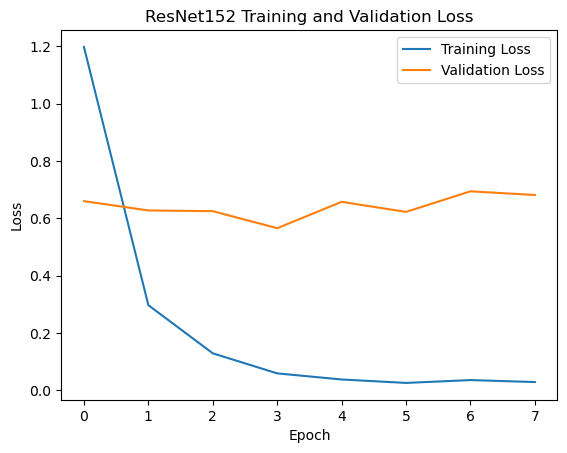

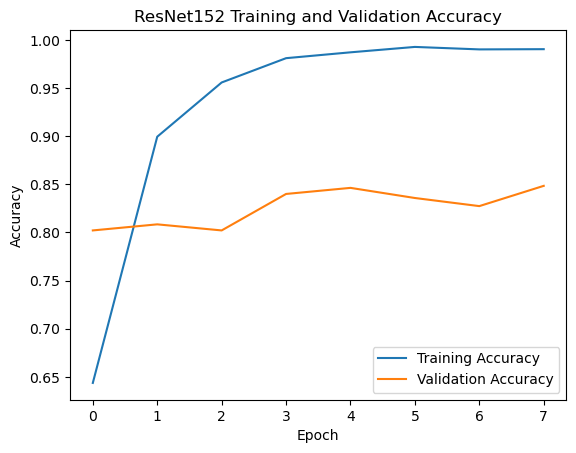

In [12]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet152 Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet152 Training and Validation Accuracy')
plt.show()

In [13]:
from sklearn.metrics import classification_report

predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = resnet_model.predict(images)
    predictions.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

true_labels = [classes[i] for i in true_labels]
predicted_labels = [classes[i] for i in predictions]

class_report = classification_report(true_labels, predicted_labels, target_names=classes)

print("ResNet152 Classification Report:")
print(class_report)


1/1 [==============================] - 4s 4s/step
ResNet152 Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.86      0.91      0.88        33
      Food Organics       0.95      0.87      0.91        47
              Glass       0.92      0.75      0.82        44
              Metal       0.73      0.93      0.82        75
Miscellaneous Trash       0.70      0.74      0.72        42
              Paper       0.84      0.88      0.86        60
            Plastic       0.89      0.79      0.84       103
      Textile Trash       0.96      0.79      0.86        28
         Vegetation       0.95      0.98      0.97        43

           accuracy                           0.85       475
          macro avg       0.87      0.85      0.85       475
       weighted avg       0.86      0.85      0.85       475



1/1 [==============================] - 4s 4s/step


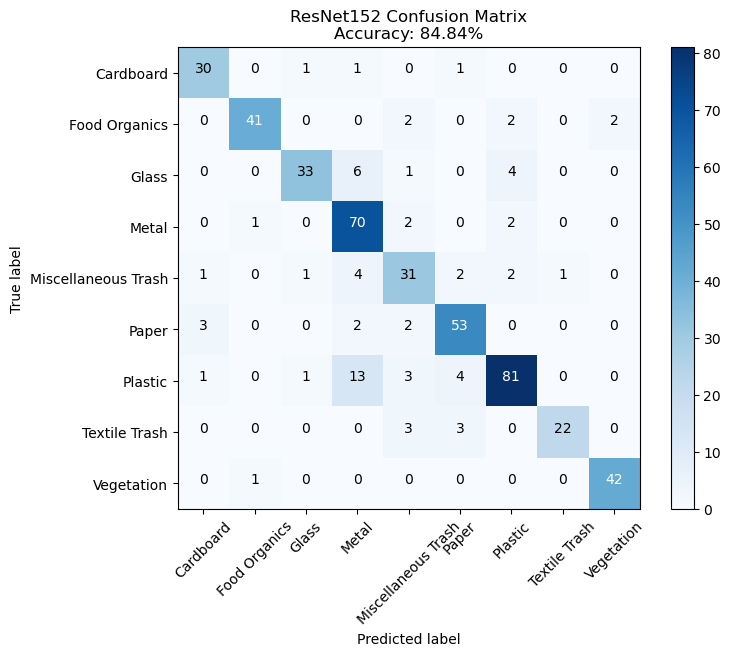

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = resnet_model.predict(images)
    predictions.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(true_labels, predictions)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
misclass = 1 - accuracy

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.title('ResNet152 Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100, misclass * 100))
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [47]:
import cv2
import numpy as np
input_width = 256
input_height = 256
def preprocess_image(image):
    image = cv2.resize(image, (input_width, input_height))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    return image
 
image_path = "../DMML 2/sample_check.png"
image = cv2.imread(image_path)
 
preprocessed_image = preprocess_image(image)
 
predictions = model.predict(preprocessed_image)
 
predicted_class = np.argmax(predictions)
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 255ms/step
Predicted class: 0


In [ ]:
image_path = "../DMML 2/sample_check.png"
image = cv2.imread(image_path)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 287ms/step


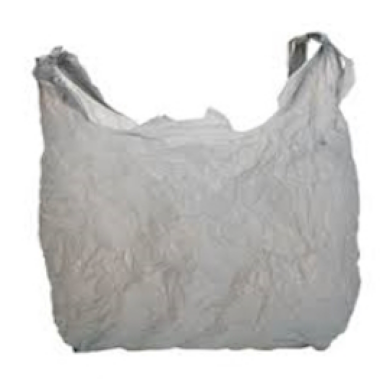

Predictions:
Cardboard: 0.006055696576368064%
Food Organics: 2.5916187951224856e-05%
Glass: 0.0025392635507159866%
Metal: 0.0003406500354685704%
Miscellaneous Trash: 5.613997578620911%
Paper: 0.02432921319268644%
Plastic: 58.31104516983032%
Textile Trash: 36.041271686553955%
Vegetation: 0.00039710116652713623%


In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_path = "../DMML 2/sample_check.png" 

preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)

plt.imshow(tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256)))
plt.axis('off')
plt.show()

print("Predictions:")
for class_index, confidence in enumerate(predictions[0]):
    class_name = classes[class_index]
    print(f"{class_name}: {confidence * 100}%")


1/1 [==============================] - 0s 264ms/step


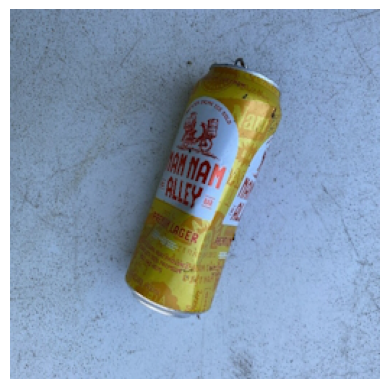

Predictions:
Cardboard: 9.014066222334804e-05%
Food Organics: 4.52472903589296e-06%
Glass: 0.0005915756901231362%
Metal: 98.44328165054321%
Miscellaneous Trash: 7.409537943203759e-05%
Paper: 8.193897826913599e-06%
Plastic: 1.555947307497263%
Textile Trash: 5.248100842791814e-08%
Vegetation: 2.5417397068907936e-12%


In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_path = "../DMML 2/metal_Sample_Check.jpg"  

preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)

plt.imshow(tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256)))
plt.axis('off')
plt.show()

print("Predictions:")
for class_index, confidence in enumerate(predictions[0]):
    class_name = classes[class_index]
    print(f"{class_name}: {confidence * 100}%")


## MobileNetV3

In [8]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', 
                                                   include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = data_augmentation(baseModel.layers[-1].output)
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/50



C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



268/268 [==============================] - 69s 240ms/step - loss: 1.0684 - accuracy: 0.6682 - val_loss: 1.7715 - val_accuracy: 0.3579
Epoch 2/50
268/268 [==============================] - 63s 234ms/step - loss: 0.5600 - accuracy: 0.8099 - val_loss: 0.7943 - val_accuracy: 0.7979
Epoch 3/50
268/268 [==============================] - 67s 251ms/step - loss: 0.4268 - accuracy: 0.8569 - val_loss: 0.4329 - val_accuracy: 0.8484
Epoch 4/50
268/268 [==============================] - 65s 243ms/step - loss: 0.3466 - accuracy: 0.8840 - val_loss: 0.3915 - val_accuracy: 0.8611
Epoch 5/50
268/268 [==============================] - 69s 255ms/step - loss: 0.2910 - accuracy: 0.9046 - val_loss: 0.4042 - val_accuracy: 0.8695
Epoch 6/50
268/268 [==============================] - 67s 251ms/step - loss: 0.2527 - accuracy: 0.9170 - val_loss: 0.3725 - val_accuracy: 0.8758
Epoch 7/50
268/268 [==============================] - 66s 247ms/step - loss: 0.2160 - accuracy: 0.9364 - val_loss: 0.3909 - val_accuracy: 0.

### Saving The Model

In [9]:
model.save("./models/mobilenet.h5")


C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Saved Model

In [11]:
model.save("./models/mobilenet.keras")

### Random Testing on Random Images on Internet

1/1 [==============================] - 2s 2s/step


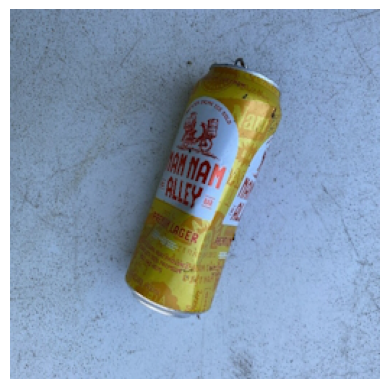

Predictions:
Cardboard: 0.9236951358616352%
Food Organics: 0.015019785496406257%
Glass: 0.06441404111683369%
Metal: 97.34882712364197%
Miscellaneous Trash: 0.009985981887439266%
Paper: 0.044826045632362366%
Plastic: 1.5904365107417107%
Textile Trash: 7.289580139513419e-05%
Vegetation: 0.0027188771127839573%


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_path = "../DMML 2/metal_Sample_Check.jpg"  # Update this with the path to your image

preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)

plt.imshow(tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256)))
plt.axis('off')
plt.show()

print("Predictions:")
for class_index, confidence in enumerate(predictions[0]):
    class_name = classes[class_index]
    print(f"{class_name}: {confidence * 100}%")


1/1 [==============================] - 0s 45ms/step


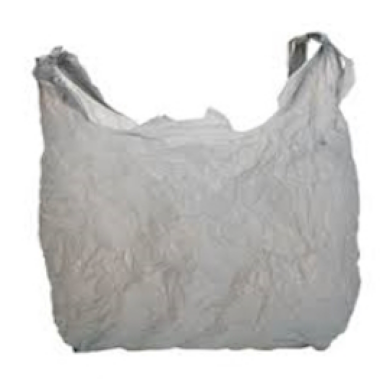

Predictions:
Cardboard: 4.421589523553848%
Food Organics: 0.0076676602475345135%
Glass: 0.010225687583442777%
Metal: 0.024979989393614233%
Miscellaneous Trash: 3.4819763153791428%
Paper: 2.1160999312996864%
Plastic: 0.000768236077419715%
Textile Trash: 88.68114948272705%
Vegetation: 1.255545299500227%


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

image_path = "../DMML 2/sample_check.png"  # Update this with the path to your image

preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)

plt.imshow(tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256)))
plt.axis('off')
plt.show()

print("Predictions:")
for class_index, confidence in enumerate(predictions[0]):
    class_name = classes[class_index]
    print(f"{class_name}: {confidence * 100}%")


1/1 [==============================] - 0s 49ms/step
[9.9998772e+01 8.8551911e-07 6.5069216e-06 1.1596603e-03 1.5026829e-06
 5.4856802e-05 4.1543579e-08 5.2262592e-08 1.1533256e-06] 
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Prediction:  Cardboard 99.99877214431763%


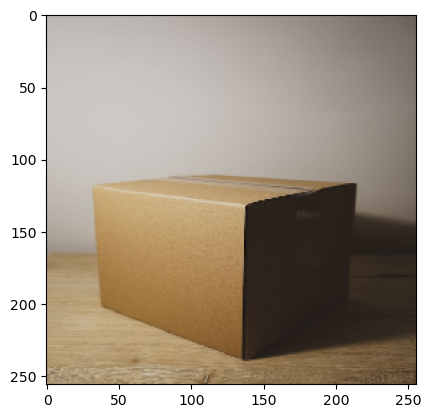

In [14]:
url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
image = tf.keras.utils.get_file("Image1.jpg", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 43ms/step
[7.2300634e+00 1.8281341e-04 3.4811550e-03 2.1482377e+00 9.0438042e+01
 6.5118512e-03 1.0213410e-03 1.6829729e-01 4.1585774e-03] 
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Prediction:  Miscellaneous Trash 90.43804407119751%


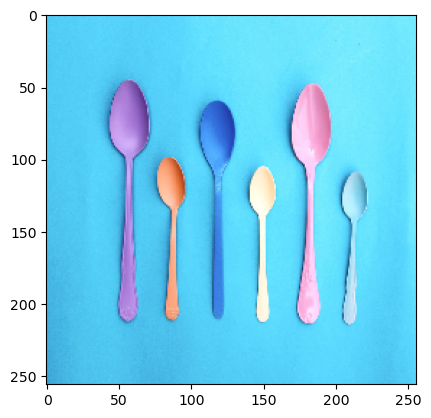

In [18]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 44ms/step
[2.5762233e-01 2.0842079e-05 2.9661987e-04 3.9807902e-04 5.6026335e+00
 7.5584757e-03 9.3828339e+01 2.9969978e-01 3.4199834e-03] 
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Prediction:  Plastic 93.8283383846283%


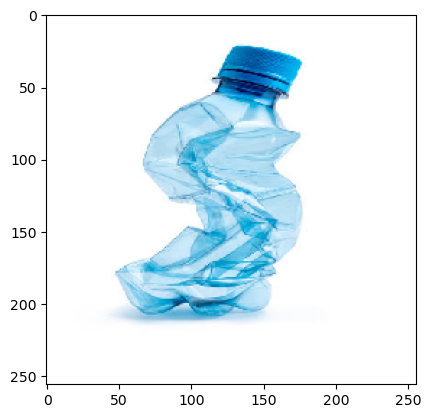

In [20]:
import requests

img_data = requests.get("https://media.istockphoto.com/id/1295052107/photo/crushed-blue-water-bottle-isolated-on-white-background.jpg?s=612x612&w=0&k=20&c=yzdEuXTRQJc38Q5mHjQRVthj4tGsT7-3VNedWo5_dJ0=").content
with open('newImg.jpg', 'wb') as handler:
    handler.write(img_data)

path = "newImg.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 48ms/step
[2.7024879e+00 4.1795588e-01 2.8602416e-02 1.4344988e+00 6.3556664e-02
 2.7600548e+00 1.6977733e-02 1.5145917e+01 7.7429947e+01] 
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Prediction:  Vegetation 77.42995023727417%


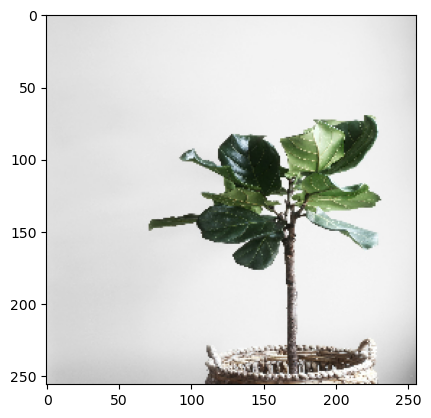

In [22]:
    

img_data = requests.get("https://images.unsplash.com/photo-1453904300235-0f2f60b15b5d?q=80&w=1886&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D").content
with open('anotherImg.jpg', 'wb') as handler:
    handler.write(img_data)

path = "anotherImg.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

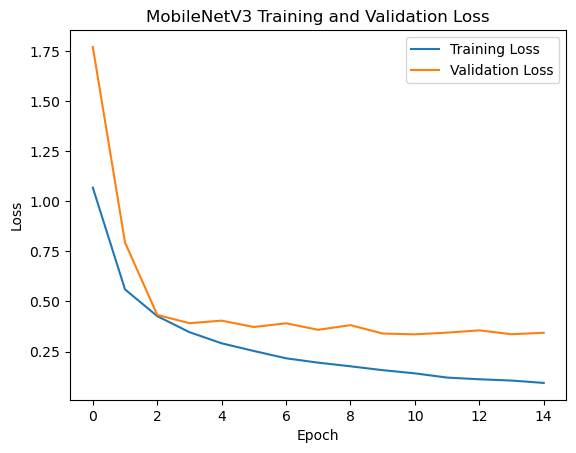

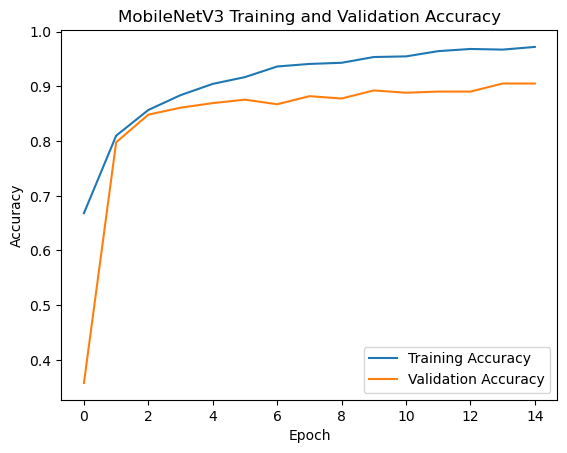

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MobileNetV3 Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetV3 Training and Validation Accuracy')
plt.show()

In [38]:
from sklearn.metrics import classification_report

predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

true_labels = [classes[i] for i in true_labels]
predicted_labels = [classes[i] for i in predictions]

class_report = classification_report(true_labels, predicted_labels, target_names=classes)

print("MobileNetV3 Classification Report:")
print(class_report)


1/1 [==============================] - 0s 137ms/step
MobileNetV3 Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.85      0.88      0.87        33
      Food Organics       0.98      0.94      0.96        47
              Glass       0.97      0.89      0.93        44
              Metal       0.84      0.96      0.89        75
Miscellaneous Trash       0.83      0.83      0.83        42
              Paper       0.95      0.88      0.91        60
            Plastic       0.91      0.89      0.90       103
      Textile Trash       0.86      0.86      0.86        28
         Vegetation       0.98      0.98      0.98        43

           accuracy                           0.91       475
          macro avg       0.91      0.90      0.90       475
       weighted avg       0.91      0.91      0.91       475



1/1 [==============================] - 0s 197ms/step


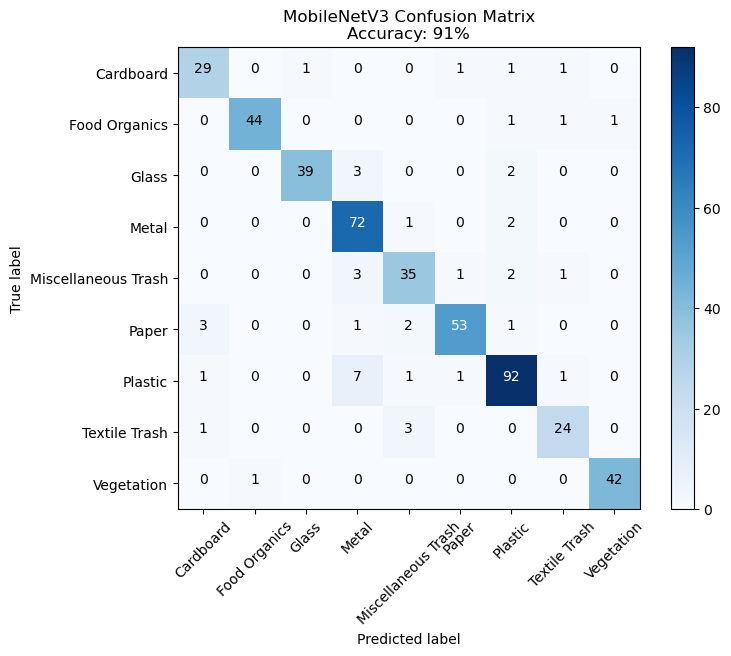

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(true_labels, predictions)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
misclass = 1 - accuracy

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.title('MobileNetV3 Confusion Matrix\nAccuracy: 91%'.format(accuracy * 100, misclass * 100))
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### Plots Over Training Data

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 46ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_108.jpg
1/1 [==============================] - 0s 48ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_133.jpg
1/1 [==============================] - 0s 60ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_135.jpg
1/1 [==============================] - 0s 47ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_137.jpg
1/1 [==============================] - 0s 46ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_14.jpg
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_140.jpg
1/1 [==============================] - 0s 45ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_142.jpg
1/1 [==============================] - 0s 53ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_144.jpg
1/1 [==============================] - 0s 47ms/step
Error on image: .

1/1 [==============================] - 0s 52ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_400.jpg
1/1 [==============================] - 0s 56ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_402.jpg
1/1 [==============================] - 0s 54ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_477.jpg


1/1 [==============================] - 0s 45ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Metal\Metal_578.jpg
1/1 [==============================] - 0s 43ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Miscellaneous Trash\Miscellaneous Trash_120.jpg
1/1 [==============================] - 0s 49ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Miscellaneous Trash\Miscellaneous Trash_236.jpg
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 55ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Plastic\Plastic_473.jpg
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Plastic\Plastic_520.jpg
1/1 [==============================] - 0s 48ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Plastic\Plastic_545.jpg
1/1 [==============================] - 0s 59ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Plastic\Plastic_562.jpg
1/1 [==============================] - 0s 44ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Textile Trash\Textile Trash_108.jpg
1/1 [==============================] - 0s 50ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Textile Trash\Textile Trash_137.jpg
1/1 [==============================] - 0s 46ms/step
Error on image: ./dataset/realwaste-main/RealWaste\Textile Trash\Textile Trash_26.jpg
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 57ms/step


<Figure size 1000x1000 with 0 Axes>

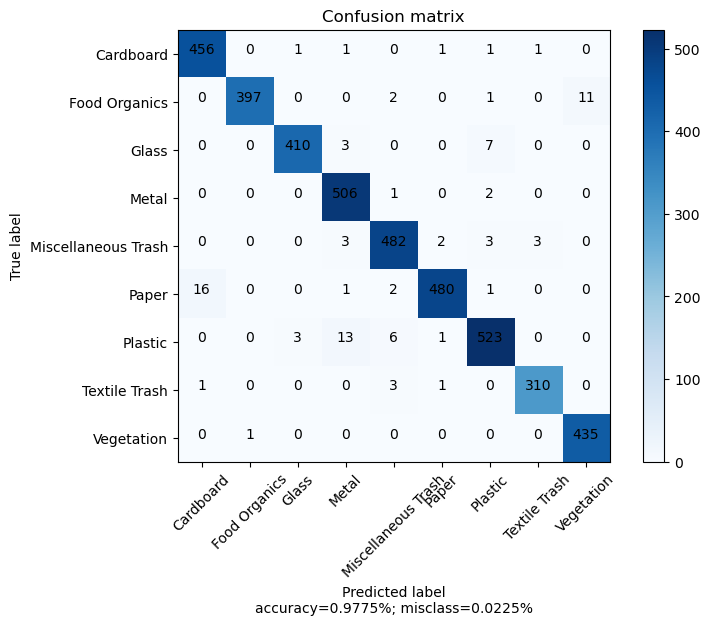

In [28]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('MobileNetV3 Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = DIR
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

In [29]:
from sklearn.metrics import classification_report

class_report = classification_report(true, predictions, target_names=classes)

print("Classification Report:")
print(class_report)


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.96      0.99      0.98       461
      Food Organics       1.00      0.97      0.98       411
              Glass       0.99      0.98      0.98       420
              Metal       0.96      0.99      0.98       509
Miscellaneous Trash       0.97      0.98      0.97       493
              Paper       0.99      0.96      0.97       500
            Plastic       0.97      0.96      0.96       546
      Textile Trash       0.99      0.98      0.99       315
         Vegetation       0.98      1.00      0.99       436

           accuracy                           0.98      4091
          macro avg       0.98      0.98      0.98      4091
       weighted avg       0.98      0.98      0.98      4091

